In [1]:
import numpy as np
import matplotlib.pyplot as plt

## 3.5 Policies and Value Functions

I will implement Example 3.5: Gridworld where the authors design a grid environment upon which an agent moves and receives rewards. The state space is a set of 25 tiles, and the action space is a movement up, down, left, or right. In this example we fix the agent's policy to the equiprobable random policy $\pi$ and we wish to compute the state-value function for this policy.

The state-value function can be computed exactly in this case by solving the Bellman equation as a system of linear equations, since this is a finite MDP problem.

Since we will generally need to compute expectation values, I need to store the problem dynamics as probability distributions somehow. Recall that the dynamics is the function $$ p\left(s', r \middle| s, a\right): \mathcal{S}\times \mathcal{R} \times \mathcal{S} \times \mathcal{A} \rightarrow \left[0,1\right] $$ subject to the obvious normalization conditions. This will generally be a 4-dimensional array.

For this particular problem, we have $\left|\mathcal{S}\right| = 25$, $\left|\mathcal{A}\right| = 4$, and $\left|\mathcal{R}\right| = 5$, so $p$ will be an array with $25^2 \times 4 \times 4 = 10,000$ entries.

I want to solve the Bellman equation --- a system of linear equations --- to find the value function for this equiprobable random policy, $\pi$. There are $\left|\mathcal{S}\right|=25$ states, and each state has a corresponding equation, so this is a system of 25 equations in 25 unknowns.

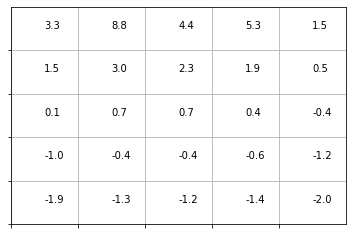

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import objects

policy = objects.get_policy_epr()
dynamics = objects.get_dynamics()
v = objects.calc_sv_exact(policy, dynamics, gamma=0.9)
objects.plot_v(v)

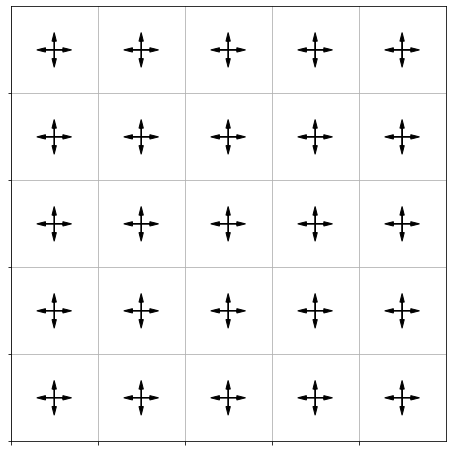

In [3]:
fig, ax = plt.subplots(figsize=(8,8))
objects.plot_policy(policy, ax=ax)

Get $q(s,a)$ from $v$

Do policy improvement

\begin{align}
    v_{\pi}\left(s\right) & := \mathbb{E}_{\pi}\left[ G_t \, \middle| \, S_t = s\right] \\
\end{align}

\begin{align}
    q_{\pi}\left(s, a\right) & := \mathbb{E}_{\pi}\left[ G_t \, \middle| \, S_t = s, A_t=a \right] \\
    & := \sum_g g \cdot p\left( g \, \middle| \, S_t = s, A_t=a \right) \\
\end{align}

\begin{align}
    q_{\pi}\left(s, a\right) & := \mathbb{E}_{\pi}\left[ G_t \, \middle| \, S_t = s, A_t=a \right] \\
    & := \mathbb{E}_{\pi}\left[ R_t + \gamma v_{\pi}\left(S_{t+1}\right) \, \middle| \, S_t = s, A_t=a \right] \\
    & = \sum_{r, s'} \left(r+ \gamma v\left(s'\right)\right) \cdot p\left( r, s' \, \middle| \, S_t = s, A_t=a \right) \\
    & =  \\

\end{align}

In [4]:
q = objects.calc_q_from_v(v, dynamics, 0.9)

In [5]:
def argmax_q(q):

    policy_new = np.zeros((25, 4))

    for i in range(q.shape[0]):
        row = q[i, :]
        idxs_max = np.argwhere(row == np.max(row)).flatten()
        p = 1.0 / len(idxs_max)
        for idx in idxs_max:
            policy_new[i, idx] = p
    return policy_new

In [6]:
policy_new = objects.argmax_q(q)

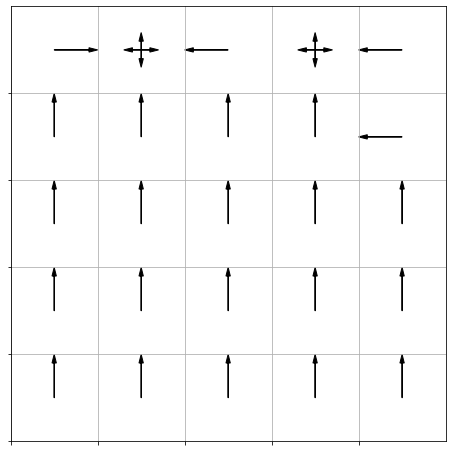

In [7]:
fig, ax = plt.subplots(figsize=(8,8))
objects.plot_policy(policy_new, ax=ax)

In [10]:
q[9,2]

1.7168145341033663

## 3.6 Optimal Policies and Optimal Value Functions

The optimal state-value function is defined as $$ v_*\left(s\right) := \max_{\pi} v_{\pi}\left(s\right), \; s\in \mathcal{S}$$ and the corresponding optimal action-value function is $$ q_*\left(s,a\right) := \max_{\pi} q_{\pi}\left(s,a\right), \; s\in \mathcal{S}.$$

The two are related by $$ q_*\left(s,a\right) = \mathbb{E}\left[ R_{t+1} + \gamma v_*\left(S_{t+1}\right) \, \middle| \, S_t = s, A_t =a \right]. $$

Since the optimal state-value function is just one particular state-value function, it must obey the usual Bellman consistency condition. Further, it satisfies the Bellman optimality equation, which is the consistency condition rewritten so as to circumvent reliance on a particular policy:

\begin{align}
    v_*\left(s\right) & = \max_{a \in \mathcal{A}\left(s\right)} q_{\pi_*}\left(s, a\right) \\
    & = \max_a \mathbb{E}_{\pi_*}\left[ G_t \, \middle| \, S_t = s, A_t = a \right] \\
    & = \max_a \mathbb{E}_{\pi_*} \left[ R_{t+1} + \gamma G_{t+1} \, \middle| \, S_t = s, A_t = a\right] \\
    & = \max_a \mathbb{E} \left[ R_{t+1} + \gamma v_*\left(S_{t+1}\right) \, \middle| \, S_t = s, A_t = a\right] \\
    & = \max_a \sum_{s', r} p\left(s', r\, \middle| \, s, a\right) \left[r + \gamma v_*\left(s'\right)\right]
\end{align}

Let's understand this derivation.

* The first line is a consistency condition between the optimal value functions $v_*$ and $q_{\pi_*}$, where $\pi_*$ is the optimal policy.
* The second line is just writing out the definition of $q_{\pi}$.
* The third line is substituting the recurrence relation $G_t = R_{t+1} + \gamma G_{t+1}$ into the expectation.
* The fourth line is ???
* The last line is the expected value written out as a sum.

Keys: 

1. If the dynamics $p$ of the problem are known, we can solve the **non-linear** system above to find the optimal state-value function, $v_{*}$.
2. When the optimal state-value function is know, we can determine an optimal policy $\pi_*$ by simply acting greedily with respect to the optimal state-value function. This is because $v_*$ has already accounted for the long-term consequences of taking actions from that particular state.

In [1]:
import sympy

In [22]:
states = range(25)
sym = [sympy.Symbol(f"v({s})") for s in states]


$$ v_*\left(s\right) = \max_a\left\{ \sum_{s', r} p\left(s', r\, \middle| \, s, a\right) \left[r + \gamma v_*\left(s'\right)\right] \right\} $$